# Assignment 2

Before working on this assignment please read these instructions fully. In the submission area, you will notice that you can click the link to **Preview the Grading** for each step of the assignment. This is the criteria that will be used for peer grading. Please familiarize yourself with the criteria before beginning the assignment.

An NOAA dataset has been stored in the file `data/C2A2_data/BinnedCsvs_d400/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv`. This is the dataset to use for this assignment. Note: The data for this assignment comes from a subset of The National Centers for Environmental Information (NCEI) [Daily Global Historical Climatology Network](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt) (GHCN-Daily). The GHCN-Daily is comprised of daily climate records from thousands of land surface stations across the globe.

Each row in the assignment datafile corresponds to a single observation.

The following variables are provided to you:

* **id** : station identification code
* **date** : date in YYYY-MM-DD format (e.g. 2012-01-24 = January 24, 2012)
* **element** : indicator of element type
    * TMAX : Maximum temperature (tenths of degrees C)
    * TMIN : Minimum temperature (tenths of degrees C)
* **value** : data value for element (tenths of degrees C)

For this assignment, you must:

1. Read the documentation and familiarize yourself with the dataset, then write some python code which returns a line graph of the record high and record low temperatures by day of the year over the period 2005-2014. The area between the record high and record low temperatures for each day should be shaded.
2. Overlay a scatter of the 2015 data for any points (highs and lows) for which the ten year record (2005-2014) record high or record low was broken in 2015.
3. Watch out for leap days (i.e. February 29th), it is reasonable to remove these points from the dataset for the purpose of this visualization.
4. Make the visual nice! Leverage principles from the first module in this course when developing your solution. Consider issues such as legends, labels, and chart junk.

The data you have been given is near **Ann Arbor, Michigan, United States**, and the stations the data comes from are shown on the map below.

In [1]:
import matplotlib.pyplot as plt
import mplleaflet
import pandas as pd
import numpy as np

from matplotlib.artist import Artist
def rec_gc(art, depth=0):
    if isinstance(art, Artist):
    # increase the depth for pretty printing
        print(" " * depth + str(art)) 
        for child in art.get_children():
            rec_gc(child, depth+2) #recursion

In [2]:
binsize = 400
hashid = 'fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89'

In [3]:
# To generate the line graph data
temp = pd.read_csv("{}.csv".format(hashid))
#Clean Dates & Temperatures
temp['Date'] = pd.to_datetime(temp['Date'])
temp['Data_Value'] = temp['Data_Value']*0.1
#Set index to dates to do datetime indexing.
temp = temp.set_index('Date')
#Remove all dates that are leap years
temp = temp[~((temp.index.month == 2) & (temp.index.day == 29))]

# Create 2 separate dataframes - one with data from 2005 to 2014, and one with 2015 data
early = temp.loc[:'2014-12-31'].sort_index().reset_index()
late = temp.loc['2015'].sort_index().reset_index()
early.head()

,Date,ID,Element,Data_Value
0,2005-01-01,USC00208080,TMAX,3.3
1,2005-01-01,USW00004848,TMIN,0.0
2,2005-01-01,USW00004848,TMAX,13.3
3,2005-01-01,USC00205050,TMIN,-1.7
4,2005-01-01,USC00200228,TMAX,15.0


In [4]:
# Create a month column and Day column.
early['Month'] = pd.DatetimeIndex(early['Date']).month
early['Day'] = pd.DatetimeIndex(early['Date']).day
#For dataframe early, create group entries in the temp list by day (primary) and element secondary
#merge the 2 dataframes
mintempdata = early[early['Element'] == 'TMIN'].groupby(['Month','Day']).agg(
    {'Data_Value': np.min}).rename(columns = {'Data_Value': 'Min'})
maxtempdata = early[early['Element'] == 'TMAX'].groupby(['Month','Day']).agg(
    {'Data_Value': np.max}).rename(columns = {'Data_Value': 'Max'})
linedata = pd.merge(mintempdata,maxtempdata, how = 'inner', 
                    left_index = True, right_index = True)
# Obtain the day of the year as an index for this data.
linedata = linedata.reset_index()
linedata.tail(7)

,Month,Day,Min,Max
358,12,25,-16.7,10.0
359,12,26,-15.6,10.6
360,12,27,-13.8,18.9
361,12,28,-16.6,19.4
362,12,29,-15.0,12.8
363,12,30,-14.4,11.7
364,12,31,-15.0,13.9


In [5]:
# To generate the scatter plot data using the dataframe 'late'
# For scatter data as well,
# Create a month column and Day column.
late['Month'] = pd.DatetimeIndex(late['Date']).month
late['Day'] = pd.DatetimeIndex(late['Date']).day
#For dataframe 'late', create group entries in the temp list by day (primary) and element secondary
#Merge the 2 dataframes
mintempdata = late[late['Element'] == 'TMIN'].groupby(['Month', 'Day']).agg(
    {'Data_Value': np.min}).rename(columns = {'Data_Value': 'Min'})
maxtempdata = late[late['Element'] == 'TMAX'].groupby(['Month', 'Day']).agg(
    {'Data_Value': np.max}).rename(columns = {'Data_Value': 'Max'})
scatterdata = pd.merge(mintempdata,maxtempdata, how = 'inner', 
                       left_index = True, right_index = True)
# Obtain the day of the year as an index for this data.
scatterdata = scatterdata.reset_index()
scatterdata.tail()

,Month,Day,Min,Max
360,12,27,-0.6,8.3
361,12,28,-3.9,6.1
362,12,29,-3.9,10.0
363,12,30,-2.2,6.7
364,12,31,-5.6,1.7


In [6]:
# Find which points which are record highs and lows and index by the 
high = scatterdata[scatterdata['Max'] > linedata['Max']]['Max']
low = scatterdata[scatterdata['Min'] < linedata['Min']]['Min']
high.head()

39      8.3
106    27.8
126    30.6
127    33.3
130    30.6
Name: Max, dtype: float64

In [7]:
xticks = (pd.date_range('31/12/2014','31/12/2015', 
                        freq ='M') + pd.Timedelta(days=1)).strftime('%-j').astype(int).tolist()
xticks = xticks[:len(xticks)-1]
xticks

[1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335]

In [8]:
high.index.tolist()

[39,
 106,
 126,
 127,
 130,
 137,
 207,
 209,
 230,
 249,
 250,
 258,
 259,
 260,
 270,
 271,
 292,
 305,
 306,
 307,
 308,
 309,
 321,
 340,
 341,
 342,
 343,
 344,
 345,
 346,
 347,
 348,
 349,
 356,
 357,
 358,
 359]

<IPython.core.display.Javascript object>


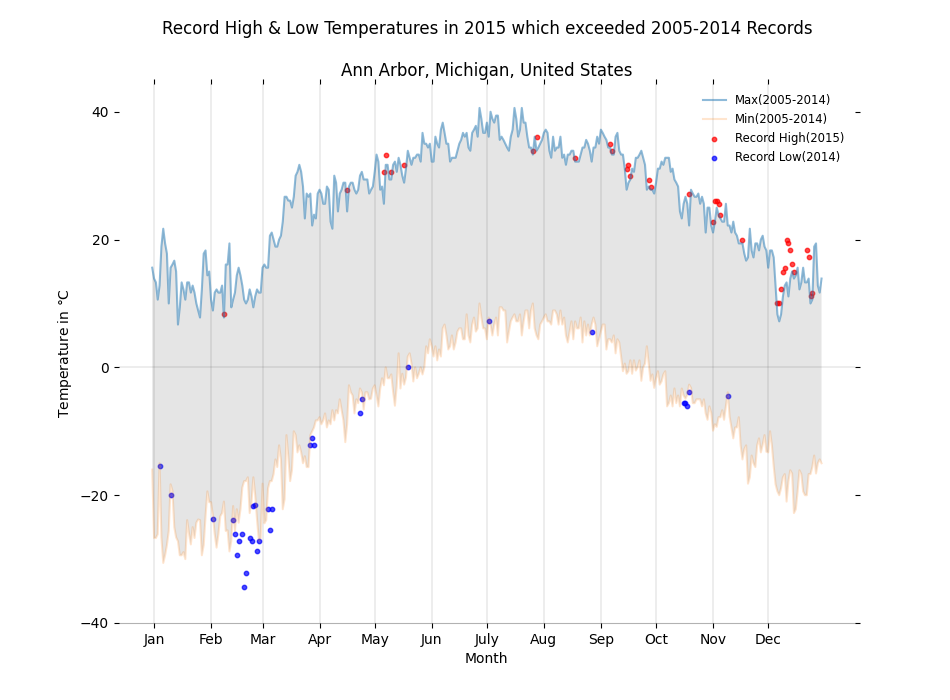

In [9]:
%matplotlib notebook
# Creating the line plot
# Create the x axis values
dates = range(365)# to set as the horizontal index
maxtemp = linedata['Max']
mintemp = linedata['Min']

#Set the figure size, figsize parameters are in inches
plt.figure(figsize =[9.5,7])
#Plot the max temp and min temp from 2005 to 2014
plt.plot(dates, maxtemp, alpha = 0.5)
plt.plot(dates, mintemp, alpha = 0.2)

#Create Axis labels for month
plt.xlabel('Month')
month = ['Jan','Feb','Mar','Apr','May','Jun','July','Aug','Sep','Oct','Nov','Dec']
plt.xticks(xticks, month)
plt.ylabel('Temperature in $\degree$C')
plt.title('''Record High & Low Temperatures in 2015 which exceeded 2005-2014 Records\n 
Ann Arbor, Michigan, United States''')

# Create scatter 2015 data
plt.scatter(high.index.tolist(), high.values, c = 'r', s = 10, alpha = 0.7)
plt.scatter(low.index.tolist(), low.values, c= 'b', s = 10, alpha = 0.7) 

#Create the fill between region.
plt.gca().fill_between([date for date in dates], 
                       mintemp, maxtemp, 
                       facecolor = "grey",
                       alpha = 0.20)
# Legend
plt.legend(loc = 'upper right', labels= ['Max(2005-2014)','Min(2005-2014)','Record High(2015)','Record Low(2014)'],
          frameon = False, fontsize = 'small', framealpha = 0.8)

#--------------Dejunkifying the plot--------------
# Remove Axis Ticks
x = plt.tick_params(top = 'off', bottom = 'off', left = 'off', right = 'off')

# Modify the y-axis labels.
plt.yticks(np.arange(-40,41, 20))

# Add a horizontal line y = 0
plt.gca().axhline(linewidth = 0.10, color = 'black')

# Remove all spines except the bottom 
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.gca().spines['bottom'].set_visible(True)
plt.gca().spines['bottom'].set_alpha(0.3)
    
# Add a Grid for the x axis
plt.grid(color = 'black', axis = 'x', linewidth = 0.10)

# Display the figure   
plt.show()

In [15]:
def leaflet_plot_stations(binsize, hashid):

    df = pd.read_csv('BinSize_d{}.csv'.format(binsize))
    df = df[df['Hash required'] == hashid]
    lons = df['LONGITUDE'].tolist()
    lats = df['LATITUDE'].tolist()

    plt.figure(figsize=(8,8))

    plt.scatter(lons, lats, c='r', alpha=0.7, s=200)

    return mplleaflet.display()

test = leaflet_plot_stations(400,'fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89')
test

KeyError: 'LONGITUDE'